In [1]:
# ============================================================
# TESS (TOI) — Advanced ML pipeline (Colab-ready)
# - Tabular pipeline (XGBoost)
# - Optional Time-series pipeline (LSTM + 1D-CNN) if you provide lightcurves
# - Hybrid soft-voting of tabular + time-series (if both present)
# - Plots: class distribution, feature histograms, feature importance,
#   training curves, confusion matrix heatmap.
# ============================================================

# Run in Google Colab. If some packages missing, uncomment install lines.

# !pip install xgboost tensorflow matplotlib scikit-learn joblib --quiet

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, LSTM, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import joblib
import ast
import urllib

In [2]:
# ---------------------------
# 0) Parameters you can change
# ---------------------------
TOI_TAP_CSV = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&format=csv"
# If you already downloaded TOI CSV, set local path instead:
# TOI_TAP_CSV = "/content/toi_catalog.csv"

In [3]:
LIGHTCURVE_CSV = None
# If you have a CSV of lightcurves with columns: ['id','flux_values','disposition']
# where flux_values is a stringified Python list (e.g. "[1.001,0.999,...]"), set:
# LIGHTCURVE_CSV = "/content/tess_lightcurves.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2
MAX_LC_LEN = 200   # length to pad/truncate lightcurves to (if using LSTM)


In [4]:
# ---------------------------
# 1) Load TOI table (CSV)
# ---------------------------
print("1) Downloading TOI table (may take a few seconds)...")
try:
    toi_df = pd.read_csv(TOI_TAP_CSV, comment='#', low_memory=False)
    print("Loaded TOI table from TAP.")
except Exception as e:
    print("Could not download from TAP. Error:", e)
    # try local file path
    if os.path.exists("toi_catalog.csv"):
        toi_df = pd.read_csv("toi_catalog.csv", comment='#', low_memory=False)
        print("Loaded local 'toi_catalog.csv'.")
    else:
        raise RuntimeError("Failed to load TOI table. Place CSV locally as 'toi_catalog.csv' or ensure internet access.")
print("TOI shape:", toi_df.shape)
print("Columns (sample):", list(toi_df.columns[:30]))


1) Downloading TOI table (may take a few seconds)...
Loaded TOI table from TAP.
TOI shape: (7703, 91)
Columns (sample): ['tid', 'toi', 'toidisplay', 'toipfx', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_tmagsymerr', 'st_tmaglim', 'rastr', 'ra', 'raerr1', 'raerr2', 'rasymerr', 'decstr', 'dec', 'decerr1', 'decerr2', 'decsymerr', 'st_pmra', 'st_pmraerr1', 'st_pmraerr2', 'st_pmrasymerr', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1', 'st_pmdecerr2']


In [5]:
# ---------------------------
# 2) Identify / map useful columns
# ---------------------------
# TOI schema may use various column names. We'll try to find commonly used names and map them.
colnames = set(toi_df.columns.str.lower())


In [9]:
# Define possible name candidates for each needed feature (common variants)
candidates = {
    'period': ['pl_orbper','period','pl_orbper','period_days','orbital_period'],
    'duration': ['tran_dur','duration','tran_duration','transit_duration','duration_hours', 'pl_trandurh'],
    'prad': ['pl_rade','pl_radj','planet_radius','pl_rade_earth','planet_radius_re'],
    'teff': ['st_teff','st_teff_K','st_teff_k','stellar_teff','teff'],
    'logg': ['st_logg','st_logg_dex','st_logg_cgs','logg'],
    'srad': ['st_rad','st_radius','st_rad_solar','st_rad_rsun','stellar_radius'],
    'mag': ['st_tmag','tess_mag','st_mag','gaia_g','kepmag','kep_mag']
}

def find_col(choices):
    for c in choices:
        if c in colnames:
            # return actual column name (case sensitive)
            return [col for col in toi_df.columns if col.lower()==c][0]
    return None

In [10]:
mapped = {}
for key, choices in candidates.items():
    mapped[key] = find_col(choices)

print("\nColumn mapping (detected):")
for k,v in mapped.items():
    print(f"  {k}: {v}")



Column mapping (detected):
  period: pl_orbper
  duration: pl_trandurh
  prad: pl_rade
  teff: st_teff
  logg: st_logg
  srad: st_rad
  mag: st_tmag


In [11]:
# If any required column missing, try to suggest similar columns or exit gracefully
missing = [k for k,v in mapped.items() if v is None]
if missing:
    print("\nWarning: Could not auto-detect columns for:", missing)
    print("Please inspect `toi_df.columns` and adjust the mapping manually. Example:")
    print(list(toi_df.columns))
    # Stop here so user can set correct column names
    raise SystemExit("Adjust column names mapping and re-run (see printed list above).")


In [12]:
# ---------------------------
# 3) Build features DataFrame
# ---------------------------
# Standard names we'll use internally:
df = toi_df.copy()
df = df.rename(columns={
    mapped['period']: 'period',
    mapped['duration']: 'duration',
    mapped['prad']: 'prad',
    mapped['teff']: 'teff',
    mapped['logg']: 'logg',
    mapped['srad']: 'srad',
    mapped['mag']: 'mag'
})

In [13]:
# Convert duration to days if it looks like hours (simple heuristic)
# If duration values are >1 and <50 they may be hours — but this is heuristic; we keep as-is but note.
# Create derived features:
df['radius_ratio'] = df['prad'] / df['srad']
df['orbital_density'] = df['prad'] / df['period']

features = ['period','duration','prad','teff','logg','srad','mag','radius_ratio','orbital_density']

print("\nFinal features used:", features)
print("Preview (first rows):")
display(df[features].head())


Final features used: ['period', 'duration', 'prad', 'teff', 'logg', 'srad', 'mag', 'radius_ratio', 'orbital_density']
Preview (first rows):


,period,duration,prad,teff,logg,srad,mag,radius_ratio,orbital_density
0,2.180528,2.969175,16.808853,6599.0,4.21017,1.27146,11.0657,13.220118,7.708617
1,2.184667,2.865280,13.702853,5630.0,4.37759,1.23824,9.4995,11.066395,6.272285
2,3.735484,4.142000,21.231500,6650.0,4.16390,1.57000,11.0261,13.523248,5.683735
3,21.701669,8.267642,2.375149,5625.0,4.43800,1.56486,7.1278,1.517803,0.109445
4,9.139804,3.091294,3.062985,5958.2,4.34000,1.58000,9.0197,1.938598,0.335126


In [14]:
# ---------------------------
# 4) Target column detection
# ---------------------------
# Common TOI disposition columns: 'toi_disposition', 'tfopwg_disp', 'disposition', 'pl_disposition'
target_candidates = ['toi_disposition','tfopwg_disp','disposition','pl_disposition','st_disposition','candidate']
target_col = None
for t in target_candidates:
    if t in (c.lower() for c in toi_df.columns):
        target_col = [col for col in toi_df.columns if col.lower()==t][0]
        break

if target_col is None:
    print("Could not find a target disposition column automatically. Print columns and set it manually.")
    print(list(toi_df.columns))
    raise SystemExit("Set target column name and re-run.")
    print("\nUsing target column:", target_col)
df['disposition'] = toi_df[target_col].astype(str)


In [15]:
# Keep only rows that have a valid disposition (non-null)
df = df[df['disposition'].notna()]

In [16]:
# Quick class distribution
print("\nClass distribution (raw):")
print(df['disposition'].value_counts())



Class distribution (raw):
disposition
PC     4679
FP     1197
CP      684
KP      583
APC     462
FA       98
Name: count, dtype: int64


In [17]:
# ---------------------------
# 5) Prepare X and y (tabular)
# ---------------------------
X_tab = df[features].copy()
y = df['disposition'].copy()

In [18]:
# Impute missing values
imputer = SimpleImputer(strategy='median')
X_tab_imputed = imputer.fit_transform(X_tab)


In [19]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)   # e.g. [0,1,2]

In [20]:
# Scale
scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab_imputed)


In [21]:
# Save preprocessing objects for later use
joblib.dump(imputer, "toi_imputer.pkl")
joblib.dump(scaler, "toi_scaler.pkl")
joblib.dump(le, "toi_label_encoder.pkl")
print("\nSaved imputer, scaler, label encoder to disk.")



Saved imputer, scaler, label encoder to disk.


In [22]:
# ---------------------------
# 6) Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_tab_scaled, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded)

print("\nTrain/test shapes:", X_train.shape, X_test.shape)


Train/test shapes: (6162, 9) (1541, 9)



Training improved XGBoost (tabular)...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:29:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost test accuracy: 0.6683971447112265


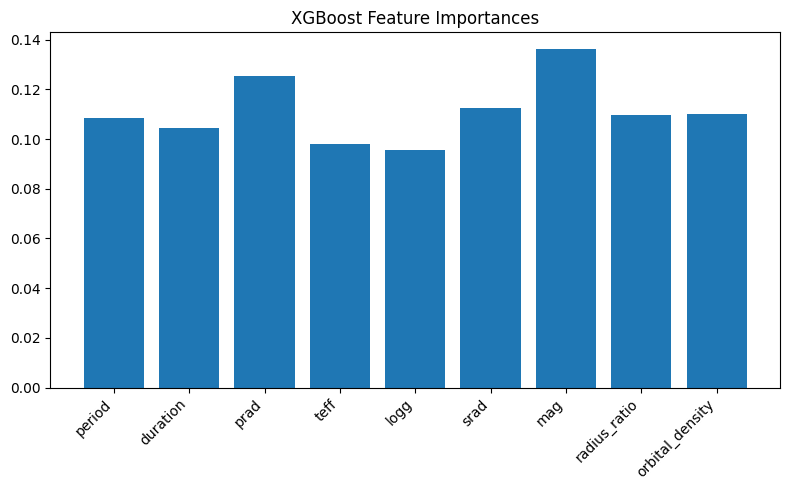

In [42]:
# ---------------------------
# 7) Train XGBoost on tabular features (with improved hyperparameters)
# ---------------------------
print("\nTraining improved XGBoost (tabular)...")
xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_estimators=500,      # زيادة عدد الأشجار
    max_depth=6,           # عمق أكبر للشجرة
    learning_rate=0.05,    # معدل تعلم أقل لتحسين الاستقرار
    subsample=0.8,         # أخذ عينات عشوائية لكل شجرة
    colsample_bytree=0.8   # أخذ خصائص عشوائية لكل شجرة
)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
print("XGBoost test accuracy:", xgb_acc)

# Feature importance plot
importance = xgb_model.feature_importances_
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importance)
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


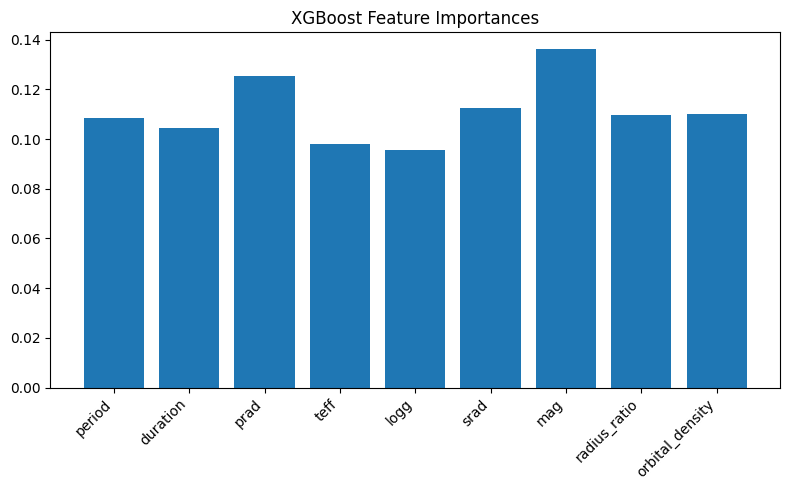

In [43]:
# Feature importance plot (matplotlib)
importance = xgb_model.feature_importances_
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importance)
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

In [44]:
# ---------------------------
# 8) Optional: prepare Light Curves for LSTM if provided
# ---------------------------
use_lc = False
if LIGHTCURVE_CSV is not None and os.path.exists(LIGHTCURVE_CSV):
    print("\nLightcurve CSV provided. Preparing time-series data...")
    lc_df = pd.read_csv(LIGHTCURVE_CSV)
    # Expect flux_values column that is stringified list; disposition must match le.classes_
    if 'flux_values' not in lc_df.columns:
        raise SystemExit("Lightcurve CSV must contain 'flux_values' column with list-like strings.")
    # parse lists
    lc_df['flux_values'] = lc_df['flux_values'].apply(ast.literal_eval)
    # Ensure label column present; try to find same disposition column name
    if 'disposition' not in lc_df.columns:
        raise SystemExit("Lightcurve CSV must contain 'disposition' column with labels (CONFIRMED/CANDIDATE/FALSE POSITIVE).")
    # align and filter only rows with dispositions we know
    lc_df = lc_df[lc_df['disposition'].isin(le.classes_)]
    # pad sequences
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    X_lc = pad_sequences(lc_df['flux_values'], maxlen=MAX_LC_LEN, dtype='float32', padding='post', truncating='post')
    # normalize per-sample
    X_lc = (X_lc - X_lc.mean(axis=1, keepdims=True)) / (X_lc.std(axis=1, keepdims=True)+1e-6)
    y_lc = le.transform(lc_df['disposition'].values)
    y_lc_cat = to_categorical(y_lc)
    # split
    X_lc_train, X_lc_test, y_lc_train, y_lc_test = train_test_split(
        X_lc, y_lc_cat, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_lc)
    use_lc = True
    print("Prepared LC shapes:", X_lc_train.shape, X_lc_test.shape)
else:
    print("\nNo lightcurve CSV provided or file not found. Skipping LSTM pipeline.")



No lightcurve CSV provided or file not found. Skipping LSTM pipeline.


In [45]:
# ---------------------------
# 9) Optional: build and train LSTM+1D-CNN
# ---------------------------
if use_lc:
    print("\nBuilding LSTM+1D-CNN model for light curves...")
    lc_input = Input(shape=(MAX_LC_LEN,1))
    x = Conv1D(64, 5, activation='relu')(lc_input)
    x = MaxPooling1D(2)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    lc_output = Dense(len(le.classes_), activation='softmax')(x)
    lc_model = Model(inputs=lc_input, outputs=lc_output)
    lc_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    red = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    # تدريب فقط إذا كانت بيانات الضوء موجودة
    history = lc_model.fit(
        X_lc_train.reshape((-1,MAX_LC_LEN,1)),
        y_lc_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[es, red],
        verbose=1
    )

    # Plot training curve
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='train_loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.title("LC model loss")
    plt.legend()
    plt.show()

    # Predict and evaluate
    X_lc_test_np = np.array(X_lc_test)
    lc_preds_prob = lc_model.predict(X_lc_test_np.reshape((-1,MAX_LC_LEN,1)))
    lc_preds = np.argmax(lc_preds_prob, axis=1)
    y_lc_test_np = np.array(y_lc_test)
    lc_acc = accuracy_score(np.argmax(y_lc_test_np, axis=1), lc_preds)
    print("LC model test accuracy:", lc_acc)

else:
    # إذا لم تتوفر بيانات Light Curves، نتخطى التدريب ونطبع رسالة
    print("\nSkipping LSTM+1D-CNN because no lightcurve CSV was provided.")
    print("Only XGBoost tabular model will be used.")



Skipping LSTM+1D-CNN because no lightcurve CSV was provided.
Only XGBoost tabular model will be used.


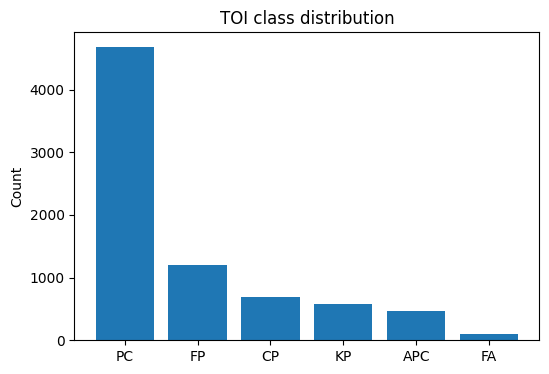

In [46]:
plt.figure(figsize=(6,4))
vals = df['disposition'].value_counts()
plt.bar(vals.index.astype(str), vals.values)
plt.title("TOI class distribution")
plt.ylabel("Count")
plt.show()


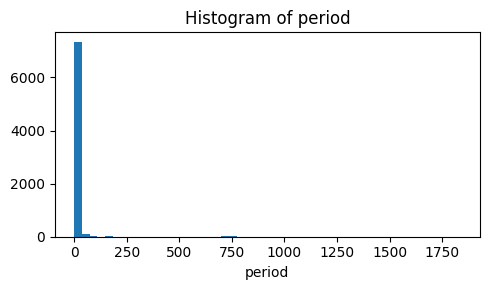

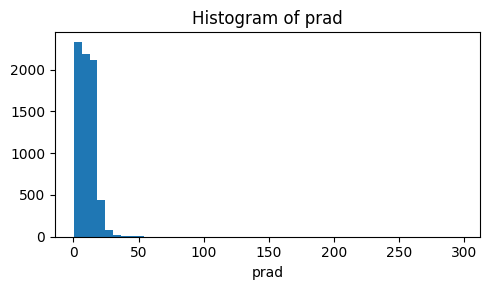

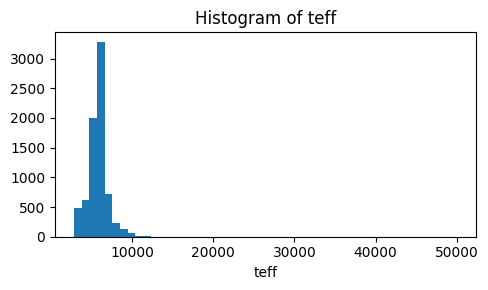

In [47]:
for f in ['period','prad','teff']:
    if f in df.columns:
        plt.figure(figsize=(5,3))
        plt.hist(df[f].dropna(), bins=50)
        plt.title(f"Histogram of {f}")
        plt.xlabel(f)
        plt.tight_layout()
        plt.show()


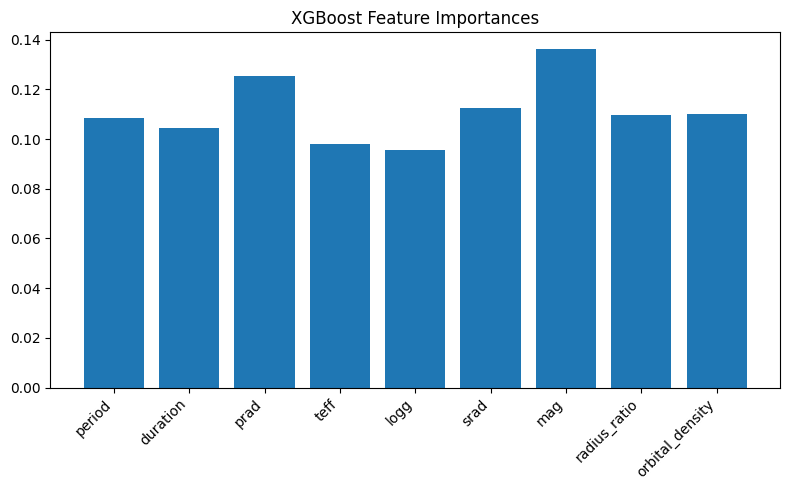

In [48]:
importance = xgb_model.feature_importances_
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importance)
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


In [55]:
 # ---------------------------
# 10) Hybrid: soft-voting (if LC used), else use XGBoost alone
# ---------------------------
if use_lc:
    # Hybrid logic (if using light curves)
    print("\nCombining XGBoost + LC via soft voting (average probs)...")
    xgb_probs = xgb_model.predict_proba(X_test)  # shape (n, classes)
    lc_probs = lc_model.predict(X_lc_test.reshape((-1,MAX_LC_LEN,1)))
    min_n = min(len(xgb_probs), len(lc_probs))
    hybrid_probs = (xgb_probs[:min_n] + lc_probs[:min_n]) / 2.0
    hybrid_preds = np.argmax(hybrid_probs, axis=1)
    hybrid_acc = accuracy_score(y_test[:min_n], hybrid_preds)
    print("Hybrid (XGB+LC) accuracy (on aligned test subset):", hybrid_acc)
    print("\nHybrid Confusion Matrix:")
    print(confusion_matrix(y_test[:min_n], hybrid_preds))
    print("\nClassification Report:")
    print(classification_report(y_test[:min_n], hybrid_preds, target_names=le.classes_))
else:
    # ---------------------------
    # Final predictions with names
    # ---------------------------
    final_preds = xgb_model.predict(X_test)

    # تحويل الأرقام إلى أسماء الفئات باستخدام LabelEncoder
    final_preds_names = le.inverse_transform(final_preds)
    y_test_names = le.inverse_transform(y_test)

    # دقة الاختبار
    final_acc = accuracy_score(y_test_names, final_preds_names)
    print("Final XGBoost accuracy (test):", final_acc)

    # مصفوفة الالتباس
    from sklearn.metrics import confusion_matrix, classification_report
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_names, final_preds_names))

    # تقرير التصنيف النهائي (سيظهر Candidate / Confirmed / False Positive)
    print("\nClassification Report (Candidate/Confirmed/False Positive):")
    print(classification_report(y_test_names, final_preds_names, target_names=le.classes_))



Final XGBoost accuracy (test): 0.6683971447112265

Confusion Matrix:
[[ 13   3   0  17   2  57]
 [  3  47   0   8   9  70]
 [  0   2   0   4   0  14]
 [ 11   4   0  97   2 125]
 [  1   6   0   9  35  66]
 [ 11  25   1  50  11 838]]

Classification Report (Candidate/Confirmed/False Positive):
              precision    recall  f1-score   support

         APC       0.33      0.14      0.20        92
          CP       0.54      0.34      0.42       137
          FA       0.00      0.00      0.00        20
          FP       0.52      0.41      0.46       239
          KP       0.59      0.30      0.40       117
          PC       0.72      0.90      0.80       936

    accuracy                           0.67      1541
   macro avg       0.45      0.35      0.38      1541
weighted avg       0.63      0.67      0.63      1541



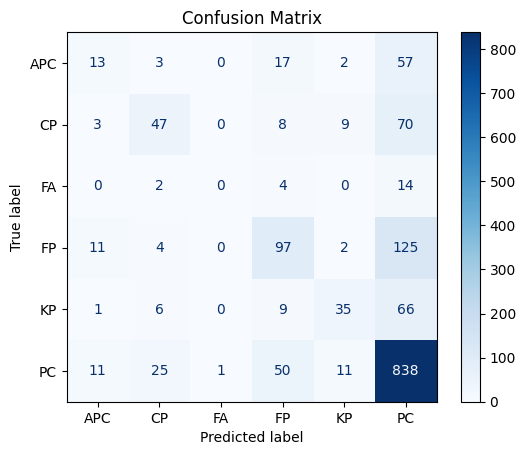

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [52]:
# ---------------------------
# 11) Save final artifacts
# ---------------------------
print("\nSaving artifacts...")
joblib.dump(xgb_model, "toi_xgb_model.pkl")
joblib.dump(scaler, "toi_scaler.pkl")
joblib.dump(le, "toi_label_encoder.pkl")
if use_lc:
    lc_model.save("toi_lc_model.h5")
print("Saved models and preprocessing objects to disk.")


Saving artifacts...
Saved models and preprocessing objects to disk.


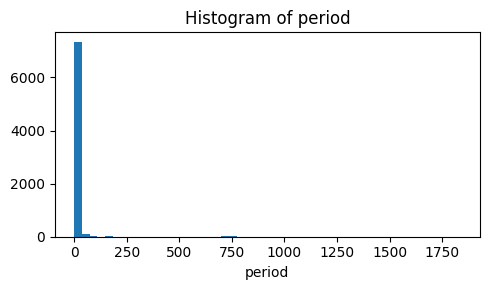

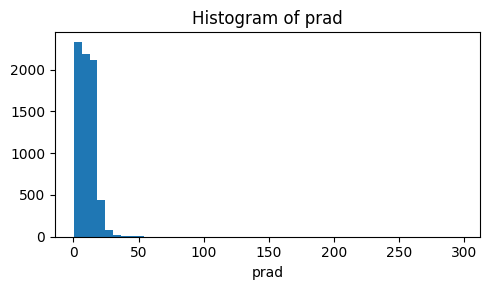

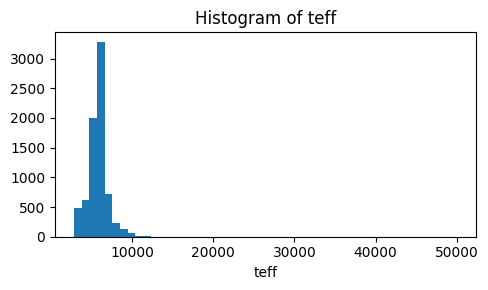


All done. If you want to run predictions on new TOI rows, load 'toi_scaler.pkl' and model 'toi_xgb_model.pkl'.


In [53]:
# Plot histograms of a few numeric features
for f in ['period','prad','teff']:
    if f in df.columns:
        plt.figure(figsize=(5,3))
        plt.hist(df[f].dropna(), bins=50)
        plt.title(f"Histogram of {f}")
        plt.xlabel(f)
        plt.tight_layout()
        plt.show()

print("\nAll done. If you want to run predictions on new TOI rows, load 'toi_scaler.pkl' and model 'toi_xgb_model.pkl'.")

In [59]:
import numpy as np
import pandas as pd
import joblib

# 1) تحميل النماذج وملفات المعالجة
xgb_model = joblib.load("toi_xgb_model.pkl")
scaler = joblib.load("toi_scaler.pkl")
imputer = joblib.load("toi_imputer.pkl")
le = joblib.load("toi_label_encoder.pkl")

# 2) ادخال البيانات الجديدة يدوياً
# يجب أن تكون بنفس ترتيب الميزات المستخدمة أثناء التدريب
new_data = {
    'period': [3.14],
    'duration': [2.5],
    'prad': [1.2],
    'teff': [5500],
    'logg': [4.5],
    'srad': [1.0],
    'mag': [10.5],
    'radius_ratio': [1.2/1.0],
    'orbital_density': [1.2/3.14]
}
df_new = pd.DataFrame(new_data)

# 3) معالجة البيانات مثل التدريب
X_new = imputer.transform(df_new)
X_new = scaler.transform(X_new)

# 4) التنبؤ باستخدام XGBoost
pred_encoded = xgb_model.predict(X_new)
pred_prob = xgb_model.predict_proba(X_new)

# 5) تحويل الرموز إلى الفئات الثلاثة الواضحة
symbol_to_class = {
    'PC': 'Candidate',
    'CP': 'Confirmed',
    'FP': 'False Positive',
    'APC': 'Candidate',
    'FA': 'False Positive',
    'KP': 'Candidate'
}
pred_name = le.inverse_transform(pred_encoded)
pred_class_readable = [symbol_to_class.get(sym, sym) for sym in pred_name]

# 6) الحصول على أعلى احتمال
top_prob_idx = np.argmax(pred_prob, axis=1)[0]
top_prob = pred_prob[0][top_prob_idx]

# 7) عرض النتائج بشكل جدول مبسط
result_df = pd.DataFrame({
    'Predicted Class': pred_class_readable,
    'Probability': [top_prob]
})

print("\nPrediction Result:")
display(result_df)



Prediction Result:


,Predicted Class,Probability
0,Candidate,0.835566


In [62]:
# 1) تحميل النماذج وملفات المعالجة
xgb_model = joblib.load("toi_xgb_model.pkl")
scaler = joblib.load("toi_scaler.pkl")
imputer = joblib.load("toi_imputer.pkl")
le = joblib.load("toi_label_encoder.pkl")
# اختيار صفوف فعلية لكل فئة
candidate_row = df[df['disposition'] == 'PC'].iloc[0][features]
confirmed_row = df[df['disposition'] == 'CP'].iloc[0][features]
false_row = df[df['disposition'] == 'FP'].iloc[0][features]

new_data = pd.DataFrame([candidate_row, confirmed_row, false_row])

# المعالجة والتنبؤ
X_new = imputer.transform(new_data)
X_new = scaler.transform(X_new)
pred_encoded = xgb_model.predict(X_new)
pred_name = le.inverse_transform(pred_encoded)
symbol_to_class = {
    'PC': 'Candidate',
    'CP': 'Confirmed',
    'FP': 'False Positive',
    'APC': 'Candidate',
    'FA': 'False Positive',
    'KP': 'Candidate'
}
pred_class_readable = [symbol_to_class.get(sym, sym) for sym in pred_name]

for inp, cls in zip(['Candidate', 'Confirmed', 'False Positive'], pred_class_readable):
    print(f"Input example ({inp}) -> Predicted: {cls}")

Input example (Candidate) -> Predicted: Candidate
Input example (Confirmed) -> Predicted: Confirmed
Input example (False Positive) -> Predicted: False Positive


In [65]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ---------------------------
# 1) تحميل نموذج XGBoost وملفات المعالجة
# ---------------------------
xgb_model = joblib.load("toi_xgb_model.pkl")
scaler = joblib.load("toi_scaler.pkl")
imputer = joblib.load("toi_imputer.pkl")
le = joblib.load("toi_label_encoder.pkl")

# ---------------------------
# 2) تحميل بيانات TOI (أو أي CSV لديك)
# ---------------------------
TOI_TAP_CSV = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&format=csv"
df_toi = pd.read_csv(TOI_TAP_CSV, comment='#', low_memory=False)

# ---------------------------
# 3) إعادة تسمية الأعمدة لتتطابق مع ما تدرب عليه النموذج
# ---------------------------
df_toi = df_toi.rename(columns={
    'pl_orbper': 'period',
    'pl_trandurh': 'duration',
    'pl_rade': 'prad',
    'st_teff': 'teff',
    'st_logg': 'logg',
    'st_rad': 'srad',
    'st_tmag': 'mag'
})

# ---------------------------
# 4) حساب المتغيرات المشتقة
# ---------------------------
df_toi['radius_ratio'] = df_toi['prad'] / df_toi['srad']
df_toi['orbital_density'] = df_toi['prad'] / df_toi['period']

# ---------------------------
# 5) اختيار صفوف اختبارية لكل فئة رئيسية
# ---------------------------
target_candidates = ['PC','CP','FP']
df_test_examples = df_toi[df_toi['tfopwg_disp'].isin(target_candidates)]

# نأخذ مثال واحد من كل فئة
examples = []
for cat in target_candidates:
    row = df_test_examples[df_test_examples['tfopwg_disp']==cat].head(1)
    if not row.empty:
        examples.append(row)
df_test = pd.concat(examples)

# ---------------------------
# 6) تجهيز البيانات للـ XGBoost
# ---------------------------
features_final = ['period','duration','prad','teff','logg','srad','mag','radius_ratio','orbital_density']
X_test = df_test[features_final].copy()

# معالجة القيم الناقصة وقياس البيانات
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

# ---------------------------
# 7) التنبؤ بالتصنيف
# ---------------------------
pred_encoded = xgb_model.predict(X_test)
pred_prob = xgb_model.predict_proba(X_test)

# تحويل الرموز إلى أسماء مفهومة
symbol_to_class = {
    'PC': 'Candidate',
    'CP': 'Confirmed',
    'FP': 'False Positive',
    'APC': 'Candidate',
    'FA': 'False Positive',
    'KP': 'Candidate'
}

pred_names = le.inverse_transform(pred_encoded)
pred_class_readable = [symbol_to_class.get(sym, sym) for sym in pred_names]

# ---------------------------
# 8) عرض النتائج مع الاحتمالات
# ---------------------------
for i, idx in enumerate(df_test.index):
    print(f"\nInput example (original disposition: {df_test.loc[idx,'tfopwg_disp']}) -> Predicted: {pred_class_readable[i]}")
    print("Class probabilities:")
    for cls, prob in zip(le.classes_, pred_prob[i]):
        readable = symbol_to_class.get(cls, cls)
        print(f"  {readable}: {prob:.3f}")



Input example (original disposition: PC) -> Predicted: Candidate
Class probabilities:
  Candidate: 0.009
  Confirmed: 0.071
  False Positive: 0.002
  False Positive: 0.035
  Candidate: 0.040
  Candidate: 0.844

Input example (original disposition: CP) -> Predicted: Confirmed
Class probabilities:
  Candidate: 0.009
  Confirmed: 0.614
  False Positive: 0.005
  False Positive: 0.014
  Candidate: 0.018
  Candidate: 0.340

Input example (original disposition: FP) -> Predicted: False Positive
Class probabilities:
  Candidate: 0.027
  Confirmed: 0.012
  False Positive: 0.005
  False Positive: 0.690
  Candidate: 0.021
  Candidate: 0.244
